In [159]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import models
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [60]:
def unicode_to_ascii(s, all_letters):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_lines(filename, all_letters):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line, all_letters) for line in lines]

def find_categories(path, all_letters):
    category_lines = []
    all_categories = []
    for filename in glob.glob(path):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = read_lines(filename, all_letters)
        for line in lines:
            category_lines.append([line, category, len(line)])
            
    np.random.shuffle(category_lines)
    return category_lines, all_categories

In [161]:
def letter_to_index(letter, all_letters):
    return all_letters.find(letter)

def line_to_tensor(line, n_letters, all_letters):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letter_to_index(letter, all_letters)] = 1
    return tensor

def get_batches(category_lines, n_categories, all_categories, n_letters, all_letters, batch_size):
    batches = []
    current = []
    batch_count = 0
    for line in category_lines:
        feature = line_to_tensor(line[0], n_letters, all_letters)
        label = torch.tensor(all_categories.index(line[1]))
        x_len = line[2]
        current.append([feature, label, x_len])
        batch_count += 1
        
        if batch_count == batch_size:
            current.sort(reverse = True, key = lambda x: x[2])
            current_features = [x[0] for x in current]
            current_labels = [x[1] for x in current]
            current_x_lens = [x[2] for x in current]
            batches.append([pad_sequence(current_features, batch_first=True), 
                            torch.stack(current_labels).type(torch.LongTensor),
                            torch.tensor(current_x_lens)])
            
            current = []
            batch_count = 0
            
    return batches

In [121]:
class Names_LSTM(nn.Module):
    
    def __init__(self, n_hidden, n_layers, n_letters, n_categories):
        super(Names_LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_categories = n_categories
        self.lstm = nn.LSTM(n_letters, n_hidden, n_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_categories)

    def forward(self, padded_input, x_lens):
        batch_size = padded_input.size(0)
        self.hidden = self.init_hidden(batch_size)
        total_length = padded_input.size(1)
        
        packed_input = pack_padded_sequence(padded_input, x_lens, batch_first=True)
        packed_lstm_out, self.hidden = self.lstm(packed_input, self.hidden)
        
        out = self.fc(self.hidden[0][-1,:,:])
        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
            weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        return hidden

In [152]:
def train_names_model(model, criterion, optimizer, batches, batch_size, device, num_epochs=30, patience=5):
    train_loss_hist = []
    valid_loss_hist = []
    valid_acc_hist = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping_count = 0
    early_stopping = False
    
    for epoch in range(num_epochs):
        if not early_stopping:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()
                if phase == 'valid':
                    model.eval()

                running_loss = 0.0
                correct = 0

                for batch_idx, batch in enumerate(batches[phase]):
                    features, labels, x_lens = batch
                    features, labels = features.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        out = model(features, x_lens)
                        loss = criterion(out, labels)
                        _, pred = torch.max(out, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * features.size(0)
                    correct += torch.sum(pred == labels.data)

                epoch_loss = running_loss/(len(batches[phase]) * batch_size)
                epoch_acc = correct.double()/(len(batches[phase]) * batch_size)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                if phase == 'valid':
                    valid_loss_hist.append(epoch_loss)
                    valid_acc_hist.append(epoch_acc.item())
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        early_stopping_count = 0
                    else:
                        early_stopping_count += 1
                        print('Early stopping count at {} out of {}'.format(early_stopping_count, patience))
                else:
                    train_loss_hist.append(epoch_loss)
                    
                if early_stopping_count >= patience:
                    print('Out of patience. Early stopping the training')
                    early_stopping = True
                
    print()
    print('Best validation accuracy: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(batches['test']):
            features, labels, x_lens = batch
            features, labels = features.to(device), labels.to(device)
            
            out = model(features, x_lens)
            _, pred = torch.max(out, 1)
            correct += torch.sum(pred == labels.data)
                
    test_acc = correct.double()/(len(batches['test']) * batch_size)
    print('Test set accuracy: {:4f}'.format(test_acc))
    print('-' * 10)
        
    return model, train_loss_hist, valid_loss_hist, valid_acc_hist, test_acc.item()

In [157]:
def run():
    PATH = 'data/names/*.txt'
    LRATE = 0.1
    NUM_EPOCHS = 30
    VALID_FRAC = 0.2
    TEST_FRAC = 0.2
    LAYERS = [1, 2]
    HIDDEN_DIM = [50, 100, 150, 200]
    BATCH_SIZES = [1, 10, 30]
    
    all_letters = string.ascii_letters + " .,;'"
    n_letters = len(all_letters)
    
    torch.cuda.manual_seed_all(42)
    sns.set()
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    
    category_lines, all_categories = find_categories(PATH, all_letters)
    n_categories = len(all_categories)
    
    test_idx = int(len(category_lines)*(1-TEST_FRAC))
    train_lines, test_lines = category_lines[:test_idx], category_lines[test_idx:]
    valid_idx = int(len(train_lines)*(1-VALID_FRAC))
    train_lines, valid_lines = train_lines[:valid_idx], train_lines[valid_idx:]
    
#     train_batches = get_batches(train_lines, n_categories, all_categories, n_letters, all_letters, 1)
#     valid_batches = get_batches(valid_lines, n_categories, all_categories, n_letters, all_letters, 1)
#     test_batches = get_batches(test_lines, n_categories, all_categories, n_letters, all_letters, 1)
    
#     batches = {'train': train_batches, 'valid': valid_batches, 'test': test_batches}
    
#     print('Task 1: Different hidden layer sizes and LSTM layers')
#     print('-' * 10)
#     for layers in LAYERS:
#         for hidden_dim in HIDDEN_DIM:
#             print('Using {} LSTM layers and {} hidden layer size'.format(layers, hidden_dim))
#             print('-' * 10)
#             model = Names_LSTM(hidden_dim, layers, n_letters, n_categories).to(device)
#             criterion = nn.CrossEntropyLoss()
#             optimizer = optim.SGD(model.parameters(), lr=LRATE)
            
#             model, train_loss_hist, valid_loss_hist, valid_acc_hist, test_acc = train_names_model(model, criterion, optimizer, batches, 1, device, NUM_EPOCHS)
    
#     print('-' * 10)
    
    print('Task 2: Different batch sizes')
    print('-' * 10)
    model = Names_LSTM(200, 1, n_letters, n_categories).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LRATE)
    for batch_size in BATCH_SIZES:
        print('Using batch size of {}'.format(batch_size))
        train_batches = get_batches(train_lines, n_categories, all_categories, n_letters, all_letters, batch_size)
        valid_batches = get_batches(valid_lines, n_categories, all_categories, n_letters, all_letters, batch_size)
        test_batches = get_batches(test_lines, n_categories, all_categories, n_letters, all_letters, batch_size)
        batches = {'train': train_batches, 'valid': valid_batches, 'test': test_batches}
        
        model, train_loss_hist, valid_loss_hist, valid_acc_hist, test_acc = train_names_model(model, criterion, optimizer, batches, batch_size, device, NUM_EPOCHS)
        
        
        fig, ax1 = plt.subplots(figsize=(8,5))

        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.plot(train_loss_hist, 'r:', label='Training Loss')
        ax1.plot(valid_loss_hist, 'r--', label='Validation Loss')

        ax2 = ax1.twinx()

        ax2.set_ylabel('Validation Accuracy')
        ax2.plot(valid_acc_hist, 'r-', label='Validation Accuracy')

        ax1.legend(loc=1)
        ax2.legend(loc=8)

        ax1.yaxis.set_major_locator(tick.LinearLocator())
        ax2.yaxis.set_major_locator(tick.LinearLocator())
        
        fig.text(.5, -0.1, 'Test accuracy = {}'.format(test_acc), ha='center')
        fig.text(.5, 1.02, 'Loss and validation accuracy over epochs for batch size {}'.format(batch_size), ha='center')

        fig.tight_layout()
        plt.show()

In [156]:
if __name__ == '__main__':
    run()

Task 1: Different hidden layer sizes and LSTM layers
----------
Using 1 LSTM layers and 50 hidden layer size
----------
Epoch 0/29
----------
train Loss: 1.2580 Acc: 0.6208
valid Loss: 1.0048 Acc: 0.6930
Epoch 1/29
----------
train Loss: 0.9317 Acc: 0.7148
valid Loss: 0.8339 Acc: 0.7447
Epoch 2/29
----------
train Loss: 0.8122 Acc: 0.7522
valid Loss: 0.7625 Acc: 0.7705
Epoch 3/29
----------
train Loss: 0.7316 Acc: 0.7722
valid Loss: 0.7303 Acc: 0.7740
Epoch 4/29
----------
train Loss: 0.6724 Acc: 0.7914
valid Loss: 0.7049 Acc: 0.7830
Epoch 5/29
----------
train Loss: 0.6211 Acc: 0.8045
valid Loss: 0.6875 Acc: 0.7945
Epoch 6/29
----------
train Loss: 0.5820 Acc: 0.8154
valid Loss: 0.6916 Acc: 0.7983
Epoch 7/29
----------
train Loss: 0.5540 Acc: 0.8240
valid Loss: 0.7032 Acc: 0.8026
Epoch 8/29
----------
train Loss: 0.5337 Acc: 0.8306
valid Loss: 0.7005 Acc: 0.8029
Epoch 9/29
----------
train Loss: 0.5214 Acc: 0.8324
valid Loss: 0.7138 Acc: 0.7936
Early stopping count at 1 out of 5
Epoch

NameError: name 'BATCH_SIZES' is not defined

Task 2: Different batch sizes
----------
Using batch size of 1
Epoch 0/29
----------
train Loss: 1.2681 Acc: 0.6189
valid Loss: 1.1551 Acc: 0.6457
Epoch 1/29
----------
train Loss: 0.9706 Acc: 0.6987
valid Loss: 1.0583 Acc: 0.6750
Epoch 2/29
----------
train Loss: 0.8370 Acc: 0.7410
valid Loss: 0.8747 Acc: 0.7263
Epoch 3/29
----------
train Loss: 0.7403 Acc: 0.7729
valid Loss: 0.7567 Acc: 0.7687
Epoch 4/29
----------
train Loss: 0.6605 Acc: 0.7965
valid Loss: 0.7286 Acc: 0.7796
Epoch 5/29
----------
train Loss: 0.5926 Acc: 0.8154
valid Loss: 0.7192 Acc: 0.7808
Epoch 6/29
----------
train Loss: 0.5372 Acc: 0.8298
valid Loss: 0.7296 Acc: 0.7877
Epoch 7/29
----------
train Loss: 0.4897 Acc: 0.8425
valid Loss: 0.7663 Acc: 0.7749
Early stopping count at 1 out of 5
Epoch 8/29
----------
train Loss: 0.4504 Acc: 0.8543
valid Loss: 0.7748 Acc: 0.7743
Early stopping count at 2 out of 5
Epoch 9/29
----------
train Loss: 0.4162 Acc: 0.8638
valid Loss: 0.8174 Acc: 0.7814
Early stopping count at 3 o

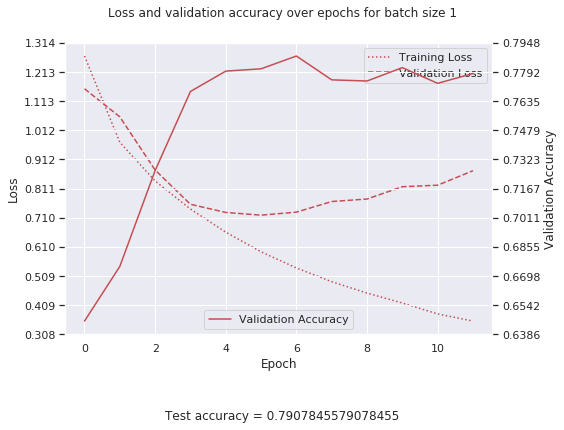

Using batch size of 10
Epoch 0/29
----------
train Loss: 0.4140 Acc: 0.8652
valid Loss: 0.6739 Acc: 0.8040
Epoch 1/29
----------
train Loss: 0.3678 Acc: 0.8814
valid Loss: 0.6790 Acc: 0.8019
Early stopping count at 1 out of 5
Epoch 2/29
----------
train Loss: 0.3404 Acc: 0.8900
valid Loss: 0.6886 Acc: 0.8016
Early stopping count at 2 out of 5
Epoch 3/29
----------
train Loss: 0.3165 Acc: 0.8977
valid Loss: 0.7001 Acc: 0.7997
Early stopping count at 3 out of 5
Epoch 4/29
----------
train Loss: 0.2941 Acc: 0.9054
valid Loss: 0.7132 Acc: 0.7969
Early stopping count at 4 out of 5
Epoch 5/29
----------
train Loss: 0.2726 Acc: 0.9125
valid Loss: 0.7283 Acc: 0.7984
Early stopping count at 5 out of 5
Out of patience. Early stopping the training

Best validation accuracy: 0.804050
Test set accuracy: 0.811222
----------


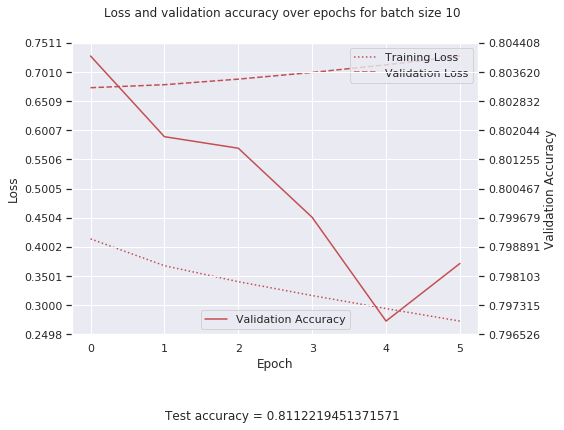

Using batch size of 30
Epoch 0/29
----------
train Loss: 0.3676 Acc: 0.8808
valid Loss: 0.6682 Acc: 0.8022
Epoch 1/29
----------
train Loss: 0.3538 Acc: 0.8847
valid Loss: 0.6697 Acc: 0.8028
Epoch 2/29
----------
train Loss: 0.3429 Acc: 0.8889
valid Loss: 0.6724 Acc: 0.8037
Epoch 3/29
----------
train Loss: 0.3330 Acc: 0.8924
valid Loss: 0.6756 Acc: 0.8037
Early stopping count at 1 out of 5
Epoch 4/29
----------
train Loss: 0.3237 Acc: 0.8953
valid Loss: 0.6794 Acc: 0.8037
Early stopping count at 2 out of 5
Epoch 5/29
----------
train Loss: 0.3146 Acc: 0.8980
valid Loss: 0.6836 Acc: 0.8040
Epoch 6/29
----------
train Loss: 0.3058 Acc: 0.9004
valid Loss: 0.6881 Acc: 0.8059
Epoch 7/29
----------
train Loss: 0.2972 Acc: 0.9024
valid Loss: 0.6929 Acc: 0.8044
Early stopping count at 1 out of 5
Epoch 8/29
----------
train Loss: 0.2888 Acc: 0.9049
valid Loss: 0.6980 Acc: 0.8009
Early stopping count at 2 out of 5
Epoch 9/29
----------
train Loss: 0.2804 Acc: 0.9090
valid Loss: 0.7034 Acc: 0.80

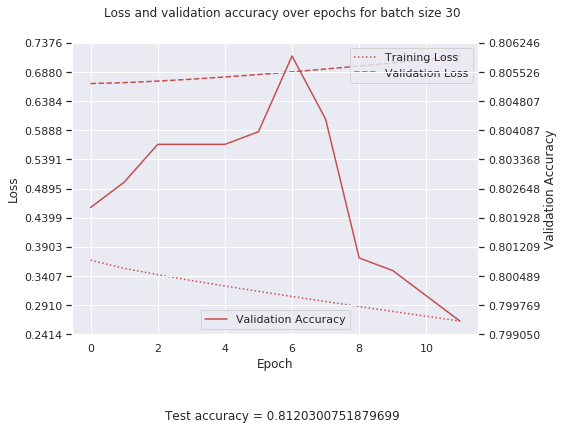

In [160]:
# if __name__ == '__main__':
#     run()